In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

Here reference level $C_{0}^{\alpha}L_{0}^{1-\alpha}$ refers to a steady state variable.

The utility is given by:
\begin{equation}
    u(C_{t},L_{t}) = \begin{cases}
    \frac{(C_{t}^{\alpha}L_{t}^{1-\alpha})^{1-\rho}}{1-\rho} \quad \text{if } C_{t}^{\alpha}L_{t}^{1-\alpha} \geq C_{0}^{\alpha}L_{0}^{1-\alpha} \\
    \frac{(C_{0}^{\alpha}L_{0}^{1-\alpha})^{1-\rho}}{1-\rho} - \lambda(\frac{(C_{0}^{\alpha}L_{0}^{1-\alpha})^{1-\rho}}{1-\rho} - \frac{(C_{t}^{\alpha}L_{t}^{1-\alpha})^{1-\rho}}{1-\rho}) \quad \text{if } C_{t}^{\alpha}L_{t}^{1-\alpha}< C_{0}^{\alpha}L_{0}^{1-\alpha} \\
\end{cases}
\end{equation}



If we reframe this a bit to make sure all the object value is positive:
\begin{equation}
    u(C_{t},L_{t}) = \begin{cases}
    \frac{(C_{t}^{\alpha}L_{t}^{1-\alpha})^{1-\rho}}{1-\rho} + (\lambda-1) \frac{(C_{0}^{\alpha}L_{0}^{1-\alpha})^{1-\rho}}{1-\rho}
    \quad \text{if } C_{t}^{\alpha}L_{t}^{1-\alpha} \geq C_{0}^{\alpha}L_{0}^{1-\alpha} \\
    \lambda \frac{(C_{t}^{\alpha}L_{t}^{1-\alpha})^{1-\rho}}{1-\rho}
    \quad \text{if } C_{t}^{\alpha}L_{t}^{1-\alpha}< C_{0}^{\alpha}L_{0}^{1-\alpha} \\
    \end{cases}
\end{equation}

In [6]:
#import package
import numpy as np
from datascience import Table
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from scipy import interpolate
from scipy import optimize
import time

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

# import data
import pandas as pd
interestTable = pd.read_csv('return_H.csv', usecols=[1,2,3])  ## Import interest rate
mortalityTable = pd.read_csv('newmort2.csv', usecols=[1,2,3])  ## Import mortality table'
Expectation = Table.from_df(interestTable)  ## Convert readin csv file to 'table'

In [7]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

In [8]:
# parameter setting
ρ = 0.5 # 5?
α = 0.9
β = 1
λ = 3

Y1 = 11.9
Y2 = 3.0 # salary

θ = 0.5

# 1.1 Read csv files

In [9]:
# results from EGM
csv1 =  pd.read_csv('Model6_VFI_74-65.csv')
csv2 = pd.read_csv('Model6_VFI_64-55.csv')
# results from VFI
# csv1 =  pd.read_csv('Model2_VFI_74-65.csv')
# csv2 = pd.read_csv('Model2_VFI_64-55.csv')

Optimal_results_VFI = Table.from_df(csv1)
Optimal_results_VFI_55_63 = Table.from_df(csv2)

In [11]:
Optimal_results_VFI_55_63.show(1)

M64,R64,C64,L64,V64,M63,R63,C63,L63,V63,M62,R62,C62,L62,V62,M61,R61,C61,L61,V61,M60,R60,C60,L60,V60,M59,R59,C59,L59,V59,M58,R58,C58,L58,V58,M57,R57,C57,L57,V57,M56,R56,C56,L56,V56,M55,R55,C55,L55,V55
1,1,1.90967,0.285714,76.5343,1,1,2.09496,0.285714,84.8577,1,1,2.23109,0.285714,93.0714,1,1,2.33075,0.285714,101.218,1,1,2.39918,0.285714,109.323,1,1,2.44032,0.285714,117.408,1,1,2.46631,0.285714,125.485,1,1,2.4747,0.285714,133.566,1,1,2.46962,0.285714,141.657,1,1,2.45371,0.285714,149.766


# Simulation for prospect theory

In [12]:
StartAge = 55

StartBal = 50 ## before consumption
StartRef_CL = 0 ## start reference level

Salary_before = 11.9
Salary_after = 3.0
print('StartRef_C = '+str(StartRef_CL))

age = np.arange(55,75)

StartRef_C = 0


In [ ]:
Upper_grid = 201 #in ($0,000) dollars
Lower_grid = 1
grids = 101
M75 = np.linspace(Lower_grid, Upper_grid, grids)
print('α=0.9, ρ=0.5, λ=3, Y1=8.5, Y2=3.0')

Upper_grid_ref = 59 #in ($0,000) dollars
Lower_grid_ref = 1
Refc_grids = 30
CL_ref75 = np.linspace(Lower_grid_ref, Upper_grid_ref, Refc_grids)

In [25]:
Numsim = 1000
np.random.seed(1)
RandomBond = np.random.choice(Expectation.column('Bond'), p = Expectation.column('Probability'), \
                 size = [Numsim,20], replace = True) ## Generate random bond return
RandomEq = np.random.choice(Expectation.column('Eq'), p = Expectation.column('Probability'), \
                 size = [Numsim,20], replace = True) ## Generate random Equity return, 1000 (individuals) * 10 (age55-64)

hide_toggle()

In [26]:
def sim(StartBal, Numsim, StartRef_CL=StartRef_CL, StartAge=StartAge, \
        Salary_before=Salary_before, Salary_after=Salary_after):

    title = []
    for i in range(20):
        title.append("age %d"%(i+55))
    Simulation_Cons = Table(np.array(title))
    Simulation_Lei = Table(np.array(title))
    Simulation_Bal = Table(np.array(title))

    # Simulate age 55-74
    for i in range(Numsim):
        Mxx = StartBal
        Ref_xx = StartRef_CL
        Cx = []
        Lx = []
        Mx = []
        for j in range(20): ## 0-9
    #         print(i, j)
            Mx.append(Mxx)
            interest = 1 + θ*RandomEq[i,j] + (1-θ)*RandomBond[i,j]
            if j<10:
                Interpolation_C = interpolate.interp2d(M75, CL_ref75, 
                                                  Optimal_results_VFI_55_63['C%1d'%(55+j)],
                                                  kind='linear')
                Interpolation_L = interpolate.interp2d(M75, CL_ref75, 
                                                  Optimal_results_VFI_55_63['L%1d'%(55+j)],
                                                  kind='linear')
                Salary = Salary_before
            else:
                Interpolation_C = interpolate.interp2d(M75, CL_ref75, 
                                                  Optimal_results_VFI['C%1d'%(55+j)],
                                                  kind='linear')
                Interpolation_L = interpolate.interp2d(M75, CL_ref75,  
                                                  Optimal_results_VFI['L%1d'%(55+j)],
                                                  kind='linear')
                Salary = Salary_after
            Cxx = Interpolation_C(Mxx, Ref_xx) # Use past year consumption as reference level
            Lxx = Interpolation_L(Mxx, Ref_xx)
            Ref_xx = Cxx * np.power((1-α)/(α*Salary), 1-α)  ## This is a formula to evolve reference level
    #         Ref_xx = np.power(Cxx,α) * np.power(Lxx,1-α)
            Cx.append(Cxx)
            Lx.append(Lxx)
            Mxx = (Mxx - Cxx + Salary*(1-Lxx)) * interest
        Simulation_Cons = Simulation_Cons.with_row(Cx)
        Simulation_Lei = Simulation_Lei.with_row(Lx)
        Simulation_Bal = Simulation_Bal.with_row(Mx)
    return Simulation_Cons, Simulation_Lei, Simulation_Bal

In [36]:
start_time = time.time()
Simulation_Cons, Simulation_Lei, Simulation_Bal = sim(StartBal=80, Numsim=1000)
print("--- %s seconds ---" % (time.time() - start_time))

C_Percentile_25 = Simulation_Cons.percentile(25)
C_Percentile_50 = Simulation_Cons.percentile(50)
C_Percentile_75 = Simulation_Cons.percentile(75)

L_Percentile_25 = Simulation_Lei.percentile(25)
L_Percentile_50 = Simulation_Lei.percentile(50)
L_Percentile_75 = Simulation_Lei.percentile(75)

M_Percentile_25 = Simulation_Bal.percentile(25)
M_Percentile_50 = Simulation_Bal.percentile(50)
M_Percentile_75 = Simulation_Bal.percentile(75)


--- 6.459142208099365 seconds ---


Text(0,0.5,'Consumption')

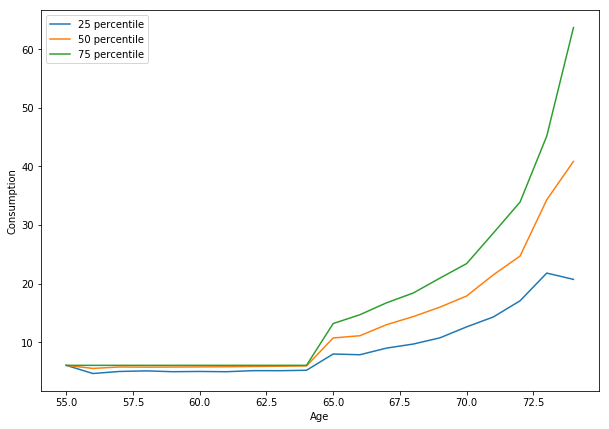

In [37]:
plt.figure(figsize=(10,7))
plt.plot(age, np.array(C_Percentile_25.row(0)), label='25 percentile')
plt.plot(age, np.array(C_Percentile_50.row(0)), label='50 percentile')
plt.plot(age, np.array(C_Percentile_75.row(0)), label='75 percentile')
plt.legend(loc='upper left')
plt.xlabel('Age')
plt.ylabel('Consumption')
# plt.ylim(0,)
# plt.savefig('Model1_cons_1000sim')

(0, 1.1)

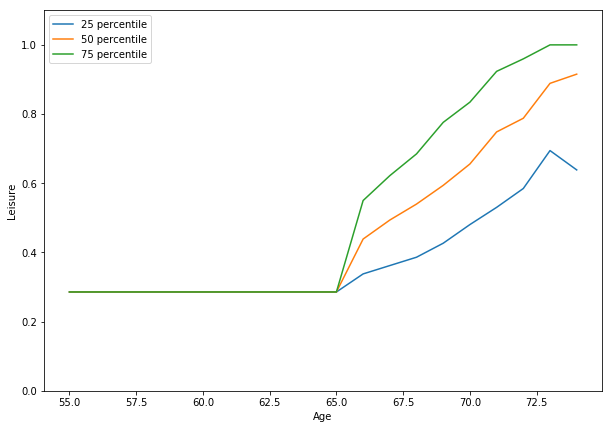

In [38]:
plt.figure(figsize=(10,7))
plt.plot(age, np.array(L_Percentile_25.row(0)), label='25 percentile')
plt.plot(age, np.array(L_Percentile_50.row(0)), label='50 percentile')
plt.plot(age, np.array(L_Percentile_75.row(0)), label='75 percentile')
plt.legend(loc='upper left')
plt.xlabel('Age')
plt.ylabel('Leisure')
plt.ylim(0, 1.1)
# plt.savefig('Model1_cons_1000sim')

Text(0,0.5,'Start-period balance')

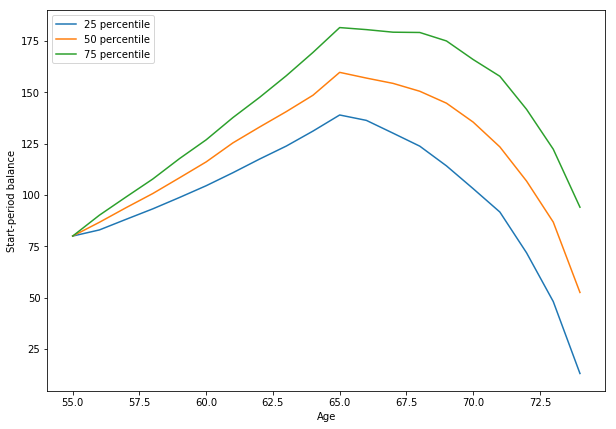

In [39]:
plt.figure(figsize=(10,7))
plt.plot(age, np.array(M_Percentile_25.row(0)), label='25 percentile')
plt.plot(age, np.array(M_Percentile_50.row(0)), label='50 percentile')
plt.plot(age, np.array(M_Percentile_75.row(0)), label='75 percentile')
plt.legend(loc='upper left')
plt.xlabel('Age')
plt.ylabel('Start-period balance')
# plt.savefig('Model1_bal_1000sim')